## LangGraph Open Deep Research - Supervisor-Researcher Architecture

In this notebook, we'll explore the **supervisor-researcher delegation architecture** for conducting deep research with LangGraph.

You can visit this repository to see the original application: [Open Deep Research](https://github.com/langchain-ai/open_deep_research)

Let's jump in!

## What We're Building

This implementation uses a **hierarchical delegation pattern** where:

1. **User Clarification** - Optionally asks clarifying questions to understand the research scope
2. **Research Brief Generation** - Transforms user messages into a structured research brief
3. **Supervisor** - A lead researcher that analyzes the brief and delegates research tasks
4. **Parallel Researchers** - Multiple sub-agents that conduct focused research simultaneously
5. **Research Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings are combined into a comprehensive report

![Architecture Diagram](https://i.imgur.com/Q8HEZn0.png)

This differs from a section-based approach by allowing dynamic task decomposition based on the research question, rather than predefined sections.

---

# 🤝 Breakout Room #1
## Deep Research Foundations

In this breakout room, we'll understand the architecture and components of the Open Deep Research system.

## Task 1: Dependencies

You'll need API keys for Anthropic (for the LLM) and Tavily (for web search). We'll configure the system to use Anthropic's Claude Sonnet 4 exclusively.

In [ ]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your key:")

## Task 2: State Definitions

The state structure is hierarchical with three levels:

### Agent State (Top Level)
Contains the overall conversation messages, research brief, accumulated notes, and final report.

### Supervisor State (Middle Level)
Manages the research supervisor's messages, research iterations, and coordinating parallel researchers.

### Researcher State (Bottom Level)
Each individual researcher has their own message history, tool call iterations, and research findings.

We also have structured outputs for tool calling:
- **ConductResearch** - Tool for supervisor to delegate research to a sub-agent
- **ResearchComplete** - Tool to signal research phase is done
- **ClarifyWithUser** - Structured output for asking clarifying questions
- **ResearchQuestion** - Structured output for the research brief

Let's import these from our library: [`open_deep_library/state.py`](open_deep_library/state.py)

In [2]:
# Import state definitions from the library
from open_deep_library.state import (
    # Main workflow states
    AgentState,           # Lines 65-72: Top-level agent state with messages, research_brief, notes, final_report
    AgentInputState,      # Lines 62-63: Input state is just messages
    
    # Supervisor states
    SupervisorState,      # Lines 74-81: Supervisor manages research delegation and iterations
    
    # Researcher states
    ResearcherState,      # Lines 83-90: Individual researcher with messages and tool iterations
    ResearcherOutputState, # Lines 92-96: Output from researcher (compressed research + raw notes)
    
    # Structured outputs for tool calling
    ConductResearch,      # Lines 15-19: Tool for delegating research to sub-agents
    ResearchComplete,     # Lines 21-22: Tool to signal research completion
    ClarifyWithUser,      # Lines 30-41: Structured output for user clarification
    ResearchQuestion,     # Lines 43-48: Structured output for research brief
)

## Task 3: Utility Functions and Tools

The system uses several key utilities:

### Search Tools
- **tavily_search** - Async web search with automatic summarization to stay within token limits
- Supports Anthropic native web search and Tavily API

### Reflection Tools
- **think_tool** - Allows researchers to reflect on their progress and plan next steps (ReAct pattern)

### Helper Utilities
- **get_all_tools** - Assembles the complete toolkit (search + MCP + reflection)
- **get_today_str** - Provides current date context for research
- Token limit handling utilities for graceful degradation

These are defined in [`open_deep_library/utils.py`](open_deep_library/utils.py)

In [3]:
# Import utility functions and tools from the library
from open_deep_library.utils import (
    # Search tool - Lines 43-136: Tavily search with automatic summarization
    tavily_search,
    
    # Reflection tool - Lines 219-244: Strategic thinking tool for ReAct pattern
    think_tool,
    
    # Tool assembly - Lines 569-597: Get all configured tools
    get_all_tools,
    
    # Date utility - Lines 872-879: Get formatted current date
    get_today_str,
    
    # Supporting utilities for error handling
    get_api_key_for_model,          # Lines 892-914: Get API keys from config or env
    is_token_limit_exceeded,         # Lines 665-701: Detect token limit errors
    get_model_token_limit,           # Lines 831-846: Look up model's token limit
    remove_up_to_last_ai_message,    # Lines 848-866: Truncate messages for retry
    anthropic_websearch_called,      # Lines 607-637: Detect Anthropic native search usage
    openai_websearch_called,         # Lines 639-658: Detect OpenAI native search usage
    get_notes_from_tool_calls,       # Lines 599-601: Extract notes from tool messages
)

## Task 4: Configuration System

The configuration system controls:

### Research Behavior
- **allow_clarification** - Whether to ask clarifying questions before research
- **max_concurrent_research_units** - How many parallel researchers can run (default: 5)
- **max_researcher_iterations** - How many times supervisor can delegate research (default: 6)
- **max_react_tool_calls** - Tool call limit per researcher (default: 10)

### Model Configuration
- **research_model** - Model for research and supervision (we'll use Anthropic)
- **compression_model** - Model for synthesizing findings
- **final_report_model** - Model for writing the final report
- **summarization_model** - Model for summarizing web search results

### Search Configuration
- **search_api** - Which search API to use (ANTHROPIC, TAVILY, or NONE)
- **max_content_length** - Character limit before summarization

Defined in [`open_deep_library/configuration.py`](open_deep_library/configuration.py)

In [4]:
# Import configuration from the library
from open_deep_library.configuration import (
    Configuration,    # Lines 38-247: Main configuration class with all settings
    SearchAPI,        # Lines 11-17: Enum for search API options (ANTHROPIC, TAVILY, NONE)
)

## Task 5: Prompt Templates

The system uses carefully engineered prompts for each phase:

### Phase 1: Clarification
**clarify_with_user_instructions** - Analyzes if the research scope is clear or needs clarification

### Phase 2: Research Brief
**transform_messages_into_research_topic_prompt** - Converts user messages into a detailed research brief

### Phase 3: Supervisor
**lead_researcher_prompt** - System prompt for the supervisor that manages delegation strategy

### Phase 4: Researcher
**research_system_prompt** - System prompt for individual researchers conducting focused research

### Phase 5: Compression
**compress_research_system_prompt** - Prompt for synthesizing research findings without losing information

### Phase 6: Final Report
**final_report_generation_prompt** - Comprehensive prompt for writing the final report

All prompts are defined in [`open_deep_library/prompts.py`](open_deep_library/prompts.py)

In [5]:
# Import prompt templates from the library
from open_deep_library.prompts import (
    clarify_with_user_instructions,                    # Lines 3-41: Ask clarifying questions
    transform_messages_into_research_topic_prompt,     # Lines 44-77: Generate research brief
    lead_researcher_prompt,                            # Lines 79-136: Supervisor system prompt
    research_system_prompt,                            # Lines 138-183: Researcher system prompt
    compress_research_system_prompt,                   # Lines 186-222: Research compression prompt
    final_report_generation_prompt,                    # Lines 228-308: Final report generation
)

## ❓ Question #1:

Explain the interrelationships between the three states (Agent, Supervisor, Researcher). Why don't we just make a single huge state?

##### Answer: The three states can be seen as three layers of responsibility at a different level. 

- Agent State (Top-Level Orchestrator): Responsible for entire cycle and final report. It holds user message, convert it to research brief, send to supervisor to delegate research, aggregate notes from all research and generate final report. It decides when to move from clarification -> research -> synthesis. The agent do not research but coordinates the workflow. 

- Supervisor State (Middle-Level Strategist): After research brief is created , it interprets the brief and decide how to decompose the problem and delegate the work across multiple researchers, it tracks the iterations and collect the notes from researchers which then it returns to Agent. The supervisor thinks about the research. 

- Researcher State (Bottom-Level Executor): There are multiple isolated and specific task associated researchers by the supervisors. Each researcher owns its message and tool calls to search and reflevt and create raw notes which researcher then compress the notes to findings and return to supervisor. Researchers only answers the specifically asked question by supervisor and do not have final research topic scope. 

Why dont we make a single huge state? : If we make one huge state there will be too overload to clarify, plan, execute, track and combine to final report. It will not be efficient and reduce quality. No parallel research will be possible, no isolation between different research topic might create bias as no decomposition of research topic. It will reduce the token efficiency as too big context require to be maintain. Also, hard to debug back. 



## ❓ Question #2:

What are the advantages and disadvantages of importing these components instead of including them in the notebook?

##### Answer: Advantage of importing these components: Better structure, ease of maintenance, separations of different aspects, ease of understanding, ease of debugging and modification. Easy to scale, more like how production grade systems are structured. Each file contains a clear responsibility and component. 

Disadvantage: Jumping between files, nothing can be seen at once like prompt, states, logic all in separate file, not very handy for quick experimentation.


## 🏗️ Activity #1: Explore the Prompts

Open `open_deep_library/prompts.py` and examine one of the prompt templates in detail.

**Requirements:**
1. Choose one prompt template (clarify, brief, supervisor, researcher, compression, or final report)
2. Explain what the prompt is designed to accomplish
3. Identify 2-3 key techniques used in the prompt (e.g., structured output, role definition, examples)
4. Suggest one improvement you might make to the prompt

**YOUR CODE HERE** - Write your analysis in a markdown cell below

 I choose supervisor prompt: lead_researcher_prompt 

 What prompt is designed to accomplish: The prompt defines the role of a lead research supervisor and responsibility to plan, delegate and coordinate the reserach. It tells explicitly not to perform the research itself. It defines the key responsibility: to interpret the research brief, decompose the problem using think_tool to independent research tasks and then delegate those tasks to specialized sub-sgent using conductresearch tool. It defines to continuously evaluate the progress using reflection tool and decide when sufficient information has been collected and signal the completion via ResearchComplete. 

 2-3 key techniques used in the prompt: 
 - Clear role and responsibility definition with appropriate boundaries. Example: 
    - The supervisor does not write the final report. 
    - The supervisor does not do direct research. 
No confusion of role which might help in improving reasoning quality. 
 - Enforcing of strict rules like when to use think_tool before delegating, after each delegation to assess progress. 
 - Clearly defining limits and constraints. For example: 
    - Hard limits on tool calls and parallel agents. 
    - Clear example of when to go for parallelization and when to use single agent. 
    - Hard limits on iteration and tokens. 

 One improvement that can be made: We can add not we mean by stop when you can anwer confidently like when there are no conflicting arguments or 2-3 sources are identified to support major claims. 

---

# 🤝 Breakout Room #2
## Building & Running the Researcher

In this breakout room, we'll explore the node functions, build the graph, and run wellness research.

## Task 6: Node Functions - The Building Blocks

Now let's look at the node functions that make up our graph. We'll import them from the library and understand what each does.

### The Complete Research Workflow

The workflow consists of 8 key nodes organized into 3 subgraphs:

1. **Main Graph Nodes:**
   - `clarify_with_user` - Entry point that checks if clarification is needed
   - `write_research_brief` - Transforms user input into structured research brief
   - `final_report_generation` - Synthesizes all research into final report

2. **Supervisor Subgraph Nodes:**
   - `supervisor` - Lead researcher that plans and delegates
   - `supervisor_tools` - Executes supervisor's tool calls (delegation, reflection)

3. **Researcher Subgraph Nodes:**
   - `researcher` - Individual researcher conducting focused research
   - `researcher_tools` - Executes researcher's tool calls (search, reflection)
   - `compress_research` - Synthesizes researcher's findings

All nodes are defined in [`open_deep_library/deep_researcher.py`](open_deep_library/deep_researcher.py)

### Node 1: clarify_with_user

**Purpose:** Analyzes user messages and asks clarifying questions if the research scope is unclear.

**Key Steps:**
1. Check if clarification is enabled in configuration
2. Use structured output to analyze if clarification is needed
3. If needed, end with a clarifying question for the user
4. If not needed, proceed to research brief with verification message

**Implementation:** [`open_deep_library/deep_researcher.py` lines 60-115](open_deep_library/deep_researcher.py#L60-L115)

In [6]:
# Import the clarify_with_user node
from open_deep_library.deep_researcher import clarify_with_user

### Node 2: write_research_brief

**Purpose:** Transforms user messages into a structured research brief for the supervisor.

**Key Steps:**
1. Use structured output to generate detailed research brief from messages
2. Initialize supervisor with system prompt and research brief
3. Set up supervisor messages with proper context

**Why this matters:** A well-structured research brief helps the supervisor make better delegation decisions.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 118-175](open_deep_library/deep_researcher.py#L118-L175)

In [7]:
# Import the write_research_brief node
from open_deep_library.deep_researcher import write_research_brief

### Node 3: supervisor

**Purpose:** Lead research supervisor that plans research strategy and delegates to sub-researchers.

**Key Steps:**
1. Configure model with three tools:
   - `ConductResearch` - Delegate research to a sub-agent
   - `ResearchComplete` - Signal that research is done
   - `think_tool` - Strategic reflection before decisions
2. Generate response based on current context
3. Increment research iteration count
4. Proceed to tool execution

**Decision Making:** The supervisor uses `think_tool` to reflect before delegating research, ensuring thoughtful decomposition of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 178-223](open_deep_library/deep_researcher.py#L178-L223)

In [8]:
# Import the supervisor node (from supervisor subgraph)
from open_deep_library.deep_researcher import supervisor

### Node 4: supervisor_tools

**Purpose:** Executes the supervisor's tool calls, including strategic thinking and research delegation.

**Key Steps:**
1. Check exit conditions:
   - Exceeded maximum iterations
   - No tool calls made
   - `ResearchComplete` called
2. Process `think_tool` calls for strategic reflection
3. Execute `ConductResearch` calls in parallel:
   - Spawn researcher subgraphs for each delegation
   - Limit to `max_concurrent_research_units` (default: 5)
   - Gather all results asynchronously
4. Aggregate findings and return to supervisor

**Parallel Execution:** This is where the magic happens - multiple researchers work simultaneously on different aspects of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 225-349](open_deep_library/deep_researcher.py#L225-L349)

In [9]:
# Import the supervisor_tools node
from open_deep_library.deep_researcher import supervisor_tools

### Node 5: researcher

**Purpose:** Individual researcher that conducts focused research on a specific topic.

**Key Steps:**
1. Load all available tools (search, MCP, reflection)
2. Configure model with tools and researcher system prompt
3. Generate response with tool calls
4. Increment tool call iteration count

**ReAct Pattern:** Researchers use `think_tool` to reflect after each search, deciding whether to continue or provide their answer.

**Available Tools:**
- Search tools (Tavily or Anthropic native search)
- `think_tool` for strategic reflection
- `ResearchComplete` to signal completion
- MCP tools (if configured)

**Implementation:** [`open_deep_library/deep_researcher.py` lines 365-424](open_deep_library/deep_researcher.py#L365-L424)

In [10]:
# Import the researcher node (from researcher subgraph)
from open_deep_library.deep_researcher import researcher

### Node 6: researcher_tools

**Purpose:** Executes the researcher's tool calls, including searches and strategic reflection.

**Key Steps:**
1. Check early exit conditions (no tool calls, native search used)
2. Execute all tool calls in parallel:
   - Search tools fetch and summarize web content
   - `think_tool` records strategic reflections
   - MCP tools execute external integrations
3. Check late exit conditions:
   - Exceeded `max_react_tool_calls` (default: 10)
   - `ResearchComplete` called
4. Continue research loop or proceed to compression

**Error Handling:** Safely handles tool execution errors and continues with available results.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 435-509](open_deep_library/deep_researcher.py#L435-L509)

In [11]:
# Import the researcher_tools node
from open_deep_library.deep_researcher import researcher_tools

### Node 7: compress_research

**Purpose:** Compresses and synthesizes research findings into a concise, structured summary.

**Key Steps:**
1. Configure compression model
2. Add compression instruction to messages
3. Attempt compression with retry logic:
   - If token limit exceeded, remove older messages
   - Retry up to 3 times
4. Extract raw notes from tool and AI messages
5. Return compressed research and raw notes

**Why Compression?** Researchers may accumulate lots of tool outputs and reflections. Compression ensures:
- All important information is preserved
- Redundant information is deduplicated
- Content stays within token limits for the final report

**Token Limit Handling:** Gracefully handles token limit errors by progressively truncating messages.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 511-585](open_deep_library/deep_researcher.py#L511-L585)

In [12]:
# Import the compress_research node
from open_deep_library.deep_researcher import compress_research

### Node 8: final_report_generation

**Purpose:** Generates the final comprehensive research report from all collected findings.

**Key Steps:**
1. Extract all notes from completed research
2. Configure final report model
3. Attempt report generation with retry logic:
   - If token limit exceeded, truncate findings by 10%
   - Retry up to 3 times
4. Return final report or error message

**Token Limit Strategy:**
- First retry: Use model's token limit × 4 as character limit
- Subsequent retries: Reduce by 10% each time
- Graceful degradation with helpful error messages

**Report Quality:** The prompt guides the model to create well-structured reports with:
- Proper headings and sections
- Inline citations
- Comprehensive coverage of all findings
- Sources section at the end

**Implementation:** [`open_deep_library/deep_researcher.py` lines 607-697](open_deep_library/deep_researcher.py#L607-L697)

In [13]:
# Import the final_report_generation node
from open_deep_library.deep_researcher import final_report_generation

## Task 7: Graph Construction - Putting It All Together

The system is organized into three interconnected graphs:

### 1. Researcher Subgraph (Bottom Level)
Handles individual focused research on a specific topic:
```
START → researcher → researcher_tools → compress_research → END
               ↑            ↓
               └────────────┘ (loops until max iterations or ResearchComplete)
```

### 2. Supervisor Subgraph (Middle Level)
Manages research delegation and coordination:
```
START → supervisor → supervisor_tools → END
            ↑              ↓
            └──────────────┘ (loops until max iterations or ResearchComplete)
            
supervisor_tools spawns multiple researcher_subgraphs in parallel
```

### 3. Main Deep Researcher Graph (Top Level)
Orchestrates the complete research workflow:
```
START → clarify_with_user → write_research_brief → research_supervisor → final_report_generation → END
                 ↓                                       (supervisor_subgraph)
               (may end early if clarification needed)
```

Let's import the compiled graphs from the library.

In [14]:
# Import the pre-compiled graphs from the library
from open_deep_library.deep_researcher import (
    # Bottom level: Individual researcher workflow
    researcher_subgraph,    # Lines 588-605: researcher → researcher_tools → compress_research
    
    # Middle level: Supervisor coordination
    supervisor_subgraph,    # Lines 351-363: supervisor → supervisor_tools (spawns researchers)
    
    # Top level: Complete research workflow
    deep_researcher,        # Lines 699-719: Main graph with all phases
)

## Why This Architecture?

### Advantages of Supervisor-Researcher Delegation

1. **Dynamic Task Decomposition**
   - Unlike section-based approaches with predefined structure, the supervisor can break down research based on the actual question
   - Adapts to different types of research (comparisons, lists, deep dives, etc.)

2. **Parallel Execution**
   - Multiple researchers work simultaneously on different aspects
   - Much faster than sequential section processing
   - Configurable parallelism (1-20 concurrent researchers)

3. **ReAct Pattern for Quality**
   - Researchers use `think_tool` to reflect after each search
   - Prevents excessive searching and improves search quality
   - Natural stopping conditions based on information sufficiency

4. **Flexible Tool Integration**
   - Easy to add MCP tools for specialized research
   - Supports multiple search APIs (Anthropic, Tavily)
   - Each researcher can use different tool combinations

5. **Graceful Token Limit Handling**
   - Compression prevents token overflow
   - Progressive truncation in final report generation
   - Research can scale to arbitrary depths

### Trade-offs

- **Complexity:** More moving parts than section-based approach
- **Cost:** Parallel researchers use more tokens (but faster)
- **Unpredictability:** Research structure emerges dynamically

## Task 8: Running the Deep Researcher

Now let's see the system in action! We'll use it to research wellness strategies for improving sleep quality.

### Setup

We need to:
1. Set up the wellness research request
2. Configure the execution with Anthropic settings
3. Run the research workflow

In [15]:
# Set up the graph with Anthropic configuration
from IPython.display import Markdown, display
import uuid

# Note: deep_researcher is already compiled from the library
# For this demo, we'll use it directly without additional checkpointing
graph = deep_researcher

print("✓ Graph ready for execution")
print("  (Note: The graph is pre-compiled from the library)")

✓ Graph ready for execution
  (Note: The graph is pre-compiled from the library)


### Configuration for Anthropic

We'll configure the system to use:
- **Claude Sonnet 4** for all research, supervision, and report generation
- **Tavily** for web search (you can also use Anthropic's native search)
- **Moderate parallelism** (1 concurrent researcher for cost control)
- **Clarification enabled** (will ask if research scope is unclear)

In [16]:
# Configure for Anthropic with moderate settings
config = {
    "configurable": {
        # Model configuration - using Claude Sonnet 4 for everything
        "research_model": "anthropic:claude-sonnet-4-20250514",
        "research_model_max_tokens": 10000,
        
        "compression_model": "anthropic:claude-sonnet-4-20250514",
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "anthropic:claude-sonnet-4-20250514",
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "anthropic:claude-sonnet-4-20250514",
        "summarization_model_max_tokens": 8192,
        
        # Research behavior
        "allow_clarification": True,
        "max_concurrent_research_units": 1,  # 1 parallel researcher
        "max_researcher_iterations": 2,      # Supervisor can delegate up to 2 times
        "max_react_tool_calls": 3,           # Each researcher can make up to 3 tool calls
        
        # Search configuration
        "search_api": "tavily",  # Using Tavily for web search
        "max_content_length": 50000,
        
        # Thread ID for this conversation
        "thread_id": str(uuid.uuid4())
    }
}

print("✓ Configuration ready")
print(f"  - Research Model: Claude Sonnet 4")
print(f"  - Max Concurrent Researchers: 1")
print(f"  - Max Iterations: 2")
print(f"  - Search API: Tavily")

✓ Configuration ready
  - Research Model: Claude Sonnet 4
  - Max Concurrent Researchers: 1
  - Max Iterations: 2
  - Search API: Tavily


### Execute the Wellness Research

Now let's run the research! We'll ask the system to research evidence-based strategies for improving sleep quality.

The workflow will:
1. **Clarify** - Check if the request is clear (may skip if obvious)
2. **Research Brief** - Transform our request into a structured brief
3. **Supervisor** - Plan research strategy and delegate to researchers
4. **Parallel Research** - Researchers gather information simultaneously
5. **Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings combined into comprehensive report

In [17]:
# Create our wellness research request
research_request = """
I want to improve my sleep quality. I currently:
- Go to bed at inconsistent times (10pm-1am)
- Use my phone in bed
- Often feel tired in the morning

Please research the best evidence-based strategies for improving sleep quality and create a comprehensive sleep improvement plan for me.
"""

# Execute the graph
async def run_research():
    """Run the research workflow and display results."""
    print("Starting research workflow...\n")
    
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": research_request}]},
        config,
        stream_mode="updates"
    ):
        # Display each step
        for node_name, node_output in event.items():
            print(f"\n{'='*60}")
            print(f"Node: {node_name}")
            print(f"{'='*60}")
            
            if node_name == "clarify_with_user":
                if "messages" in node_output:
                    last_msg = node_output["messages"][-1]
                    print(f"\n{last_msg.content}")
            
            elif node_name == "write_research_brief":
                if "research_brief" in node_output:
                    print(f"\nResearch Brief Generated:")
                    print(f"{node_output['research_brief'][:500]}...")
            
            elif node_name == "supervisor":
                print(f"\nSupervisor planning research strategy...")
                if "supervisor_messages" in node_output:
                    last_msg = node_output["supervisor_messages"][-1]
                    if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                        print(f"Tool calls: {len(last_msg.tool_calls)}")
                        for tc in last_msg.tool_calls:
                            print(f"  - {tc['name']}")
            
            elif node_name == "supervisor_tools":
                print(f"\nExecuting supervisor's tool calls...")
                if "notes" in node_output:
                    print(f"Research notes collected: {len(node_output['notes'])}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print(f"\n" + "="*60)
                    print("FINAL REPORT GENERATED")
                    print("="*60 + "\n")
                    display(Markdown(node_output["final_report"]))
    
    print("\n" + "="*60)
    print("Research workflow completed!")
    print("="*60)

# Run the research
await run_research()

Starting research workflow...


Node: clarify_with_user

I have sufficient information to proceed with your sleep improvement research. I understand you're looking for evidence-based strategies to address your current sleep challenges: inconsistent bedtimes (10pm-1am range), phone use in bed, and morning fatigue. I'll research comprehensive, science-backed sleep improvement strategies and create a personalized plan that addresses these specific issues. Beginning research now.

Node: write_research_brief

Research Brief Generated:
I want to improve my sleep quality and need a comprehensive, evidence-based sleep improvement plan. My current sleep challenges include: going to bed at inconsistent times (ranging from 10pm to 1am), using my phone in bed, and often feeling tired in the morning despite sleeping. Please research the most effective, scientifically-backed strategies for improving sleep quality that specifically address inconsistent bedtime schedules, electronic device usage befor


Node: research_supervisor

Node: final_report_generation

FINAL REPORT GENERATED



# Evidence-Based Sleep Improvement Plan: Comprehensive Strategy for Better Sleep Quality

## Sleep Timing Consistency and Circadian Rhythm Regulation

Your inconsistent bedtimes (10pm-1am) are significantly impacting your sleep quality and overall well-being. Research demonstrates that irregular sleep schedules create profound physiological disruptions that extend far beyond simple tiredness.

A comprehensive study of 160 university students found that 73.1% experienced irregular bedtimes more than once per week, with those in the high frequency group (≥3 nights/week) showing significantly poorer sleep quality as measured by standardized sleep assessments [1]. More concerning, irregular bedtime frequency was negatively correlated with total daily sleep time, meaning inconsistent schedules actually reduce the amount of sleep you get.

The physiological impact is dramatic. Research using a Sleep Regularity Index found that students with irregular sleep schedules had circadian rhythms delayed by 2.6 hours compared to regular sleepers - essentially equivalent to living 2-3 time zones westward [2]. Despite sleeping the same total hours (approximately 7 hours), irregular sleepers obtained significantly less nighttime sleep (42% vs. 55% of night hours) and compensated with more daytime napping (3 times more episodes per week) [2].

Perhaps most importantly, this research revealed a direct correlation between sleep regularity and academic performance, with every 10-point increase in sleep regularity corresponding to a 0.10 increase in GPA [2]. Another study of 223 college students found that with every additional hour of irregular/mistimed sleep, participants reported feeling sadder, sicker, and more stressed by approximately 6 points on well-being scales [3].

**Action Plan for Sleep Timing:**
- Choose a consistent bedtime between 10pm-11pm and stick to it within 30 minutes every night
- Set a fixed wake-up time regardless of weekday or weekend
- Use light exposure strategically: bright light in the morning, dimmer light 2 hours before bed
- If you must adjust your schedule, do so gradually by 15-30 minutes per night

## Electronic Device Usage and Blue Light Management

Your phone use in bed is creating a cascade of sleep-disrupting effects that research shows can be precisely measured and addressed. Blue light exposure from electronic devices suppresses melatonin production and delays your natural sleep onset.

Recent research comparing red and blue LED light exposure found that after two hours, blue light maintained melatonin suppression at 7.5 pg/mL while red light allowed recovery to 26.0 pg/mL [4]. This suppression effect is particularly strong in younger individuals and men. A controlled study examining smartphone use for 150 minutes before bed (7:30-10:00 PM) found significant decreases in sleepiness, increased cognitive errors, and extended the time to reach natural melatonin onset by approximately 14 minutes [5].

The effects extend beyond just melatonin suppression. A systematic review of 36 studies found that blue light exposure decreased tiredness in 50% of studies, decreased sleep quality in 20%, decreased sleep duration in 33%, and increased sleep latency (time to fall asleep) in nearly half of all studies [6]. However, the same research showed increased alertness and cognitive performance, explaining why your phone feels engaging when you should be winding down.

**Technology Boundary Implementation:**
- Implement a complete digital sunset 60-90 minutes before your target bedtime
- Remove all electronic devices from the bedroom, including charging stations
- Use a traditional alarm clock instead of your phone
- If evening device use is necessary, use blue light filtering glasses or apps after 8pm
- Replace pre-bed phone scrolling with reading, gentle stretching, or meditation
- Consider red-light reading lamps for evening activities

## Morning Fatigue Solutions and Sleep Inertia Management

Your morning tiredness despite sleeping is likely due to sleep inertia - a transitional state of lowered arousal occurring immediately after awakening that produces temporary performance decrements [7]. This is particularly intense when awakening during slow wave sleep or when your wake time conflicts with your natural circadian rhythm.

Sleep inertia appears more intense when awakening occurs near the trough of core body temperature (typically 4-6am for most people) compared to its circadian peak [7]. Your irregular bedtimes are likely causing you to wake up at suboptimal circadian phases, intensifying morning grogginess. Prior sleep deprivation enhances sleep inertia by increasing the amount of deep sleep your brain tries to obtain [7].

Research indicates that in the absence of major sleep deprivation, sleep inertia rarely exceeds 30 minutes, but your inconsistent schedule may be prolonging this state [7]. Different cognitive functions recover at different rates, with complex decision-making taking longer to normalize than simple motor tasks.

**Morning Energy Optimization:**
- Use a smart alarm or sleep tracking app to wake during lighter sleep phases
- Consume 100mg of caffeine immediately upon waking (research-proven to reduce sleep inertia) [8]
- Splash cold water on your face within minutes of waking
- Get bright light exposure within 30 minutes of waking, preferably natural sunlight
- Keep wake times consistent even on weekends to maintain circadian alignment
- Allow 30-45 minutes for full cognitive recovery before important tasks

## Bedroom Environment Optimization

Your sleep environment plays a crucial role in both sleep initiation and maintenance. Research from multiple institutions provides specific, evidence-based parameters for optimal sleep conditions.

**Temperature Control:** Studies consistently show that 65°F (18.3°C) is the ideal bedroom temperature for most people [9]. This cooler setting supports the natural drop in core body temperature that occurs during sleep and promotes sleepiness. Stanford research confirms that temperatures between 60-67°F support the natural wind-down process [10].

**Noise Management:** Even low-level noise can shift sleepers to lighter sleep stages, while loud disturbances cause severe sleep fragmentation with negative impacts on physical and mental health [9]. Solutions include white noise machines, fans, or noise-blocking curtains to create consistent acoustic environments.

**Light Control:** Exposure to artificial light in the evening delays circadian rhythms and prolongs sleep onset. Light levels should be kept as low as possible in bedrooms, with blackout curtains or eye masks recommended for complete darkness [9].

**Air Quality and Ventilation:** Emerging evidence shows that bedroom environmental quality significantly impacts sleep, with current indoor air quality standards being inadequate for sleep-specific needs [11]. Proper ventilation and air circulation support better sleep quality.

**Environmental Setup Checklist:**
- Set thermostat to 65°F (adjust 1-2 degrees based on personal comfort)
- Install blackout curtains or use eye masks
- Use white noise machines or earplugs to mask disruptive sounds
- Ensure proper mattress support (studies show newer mattresses improve sleep quality and reduce back pain)
- Consider lavender essential oil, which research shows can improve sleep quality and morning refreshedness [9]
- Remove or cover LED lights from electronics
- Ensure adequate ventilation and air circulation

## Comprehensive Sleep Hygiene Protocol

Sleep hygiene encompasses both environmental factors and daily routines that promote consistent, uninterrupted sleep. Research demonstrates that forming good sleep habits is central to health, with sleep hygiene education showing significant effectiveness across diverse populations [12].

The Sleep Foundation defines strong sleep hygiene as having both optimal bedroom conditions and daily routines that support quality sleep [13]. Multiple peer-reviewed studies from 2021-2023 demonstrate effectiveness across various populations, including university students, elderly individuals, and medical patients [12].

**Daily Sleep Hygiene Routine:**

**Morning (Upon Waking):**
- Maintain fixed wake-up time (within 30 minutes) regardless of weekday/weekend
- Get bright light exposure within 30 minutes of waking
- Consume caffeine strategically (before 10am for most people)

**Daytime:**
- Exercise regularly but avoid intense exercise within 3 hours of bedtime
- Get natural daylight exposure to support circadian rhythm regulation
- Limit afternoon/evening caffeine intake (avoid after 2pm if sensitive)

**Evening (3-4 hours before bed):**
- Avoid large meals, alcohol, and smoking
- Begin dimming lights throughout your living space
- Engage in calming activities rather than stimulating content

**Pre-Bed Routine (60-90 minutes before sleep):**
- Implement digital sunset (no screens)
- Budget 30 minutes for consistent winding-down activities
- Keep bedroom activities restricted to sleep and intimacy only
- Practice relaxation techniques like reading, gentle stretching, or meditation

**Sleep Environment:**
- Maintain bedroom temperature at 65°F
- Ensure complete darkness and minimal noise
- Use comfortable, supportive bedding
- Keep bedroom well-ventilated

## Implementation Strategy and Timeline

**Week 1-2: Foundation Building**
- Establish consistent bedtime (choose between 10-10:30pm)
- Remove all electronic devices from bedroom
- Set up optimal bedroom environment (temperature, darkness, noise control)

**Week 3-4: Routine Refinement**
- Fine-tune pre-bed routine timing and activities
- Adjust wake time to ensure 7-8 hours of sleep opportunity
- Begin morning light exposure routine

**Week 5-6: Optimization**
- Monitor and adjust based on sleep quality improvements
- Address any remaining morning fatigue with strategic interventions
- Establish weekend consistency to maintain progress

**Long-term Maintenance:**
- Track sleep quality using validated measures
- Make gradual adjustments as needed
- Maintain consistency even during stressful periods or schedule changes

Research shows that sleep hygiene interventions can significantly improve sleep quality, reduce daytime sleepiness and fatigue, and enhance overall well-being when implemented consistently [12]. The key is treating this as a comprehensive lifestyle change rather than temporary modifications, as the benefits compound over time with sustained practice.

### Sources

[1] Effects of an irregular bedtime schedule on sleep quality: https://pmc.ncbi.nlm.nih.gov/articles/PMC2718885/

[2] Irregular sleep/wake patterns are associated with poorer: https://www.nature.com/articles/s41598-017-03171-4

[3] Irregular sleep and event schedules are associated with: https://pmc.ncbi.nlm.nih.gov/articles/PMC7294408/

[4] Comparative Effects of Red and Blue LED Light on Melatonin Levels: https://pmc.ncbi.nlm.nih.gov/articles/PMC12113466/

[5] Effects of smartphone use with and without blue light at night in: https://www.sciencedirect.com/science/article/abs/pii/S0022395616307786

[6] The influence of blue light on sleep, performance and wellbeing in: https://pmc.ncbi.nlm.nih.gov/articles/PMC9424753/

[7] Sleep inertia - ScienceDirect.com: https://www.sciencedirect.com/science/article/abs/pii/S1087079200900984

[8] Most sleep tips shared on TikTok are supported by scientific evidence: https://www.sleepmeeting.org/most-sleep-tips-shared-on-tiktok-are-supported-by-scientific-evidence/

[9] Bedroom Environment: What Elements Are Important?: https://www.sleepfoundation.org/bedroom-environment

[10] 5 Simple Changes to Your Bedroom for Better Sleep: https://lifestylemedicine.stanford.edu/bedroom-changes-sleep-routine/

[11] Sleep Environment - International Society of Indoor Air Quality and: https://www.isiaq.org/sleep_environment.php

[12] Sleep hygiene efficacy on quality of sleep and mental ability among: https://journals.lww.com/jfmpc/fulltext/2024/13100/sleep_hygiene_efficacy_on_quality_of_sleep_and.87.aspx

[13] Mastering Sleep Hygiene: Your Path to Quality Sleep: https://www.sleepfoundation.org/sleep-hygiene


Research workflow completed!


## Task 9: Understanding the Output

Let's break down what happened:

### Phase 1: Clarification
The system checked if your request was clear. Since you provided specific details about your sleep issues, it likely proceeded without asking clarifying questions.

### Phase 2: Research Brief
Your request was transformed into a detailed research brief that guides the supervisor's delegation strategy.

### Phase 3: Supervisor Delegation
The supervisor analyzed the brief and decided how to break down the research:
- Used `think_tool` to plan strategy
- Called `ConductResearch` to delegate to researchers
- Each delegation specified a focused research topic (e.g., sleep hygiene, circadian rhythm, blue light effects)

### Phase 4: Parallel Research
Researchers worked on their assigned topics:
- Each researcher used web search tools to gather information
- Used `think_tool` to reflect after each search
- Decided when they had enough information
- Compressed their findings into clean summaries

### Phase 5: Final Report
All research findings were synthesized into a comprehensive sleep improvement plan with:
- Well-structured sections
- Evidence-based recommendations
- Practical action items
- Sources for further reading

## Task 10: Key Takeaways & Next Steps

### Architecture Benefits
1. **Dynamic Decomposition** - Research structure emerges from the question, not predefined
2. **Parallel Efficiency** - Multiple researchers work simultaneously
3. **ReAct Quality** - Strategic reflection improves search decisions
4. **Scalability** - Handles token limits gracefully through compression
5. **Flexibility** - Easy to add new tools and capabilities

### When to Use This Pattern
- **Complex research questions** that need multi-angle investigation
- **Comparison tasks** where parallel research on different topics is beneficial
- **Open-ended exploration** where structure should emerge dynamically
- **Time-sensitive research** where parallel execution speeds up results

### When to Use Section-Based Instead
- **Highly structured reports** with predefined format requirements
- **Template-based content** where sections are always the same
- **Sequential dependencies** where later sections depend on earlier ones
- **Budget constraints** where token efficiency is critical

### Extend the System
1. **Add MCP Tools** - Integrate specialized tools for your domain
2. **Custom Prompts** - Modify prompts for specific research types
3. **Different Models** - Try different Claude versions or mix models
4. **Persistence** - Use a real database for checkpointing instead of memory

### Learn More
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Open Deep Research Repo](https://github.com/langchain-ai/open_deep_research)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)
- [Tavily Search API](https://tavily.com/)

## ❓ Question #3:

What are the trade-offs of using parallel researchers vs. sequential research? When might you choose one approach over the other?

##### Answer: 

Parallel Researchers:

Advantages: Speed of execution (less research time) and efficiency, multiple decomposed topics can be explored simultaneously, isolation between research topics reduce possible biases. 

Disadvantages: High cost of tokens, possible overlap between research point, alot of coordination at supervisor end, could be hard to debug and track errors. 

Sequential Researchers: 

Advantages: Lower cost of tokens only one agent runs at a time, simpler management and workflow, controlled execution. 

Disadvantages: More time taken for research, hard to do all possible research, later research might have influence of early notes because everything is sequential developing context and biases. 

When to choose which type of researchers: 

Parallel: For multi-topic research where speed and depth of research matters. 

Sequential: For dependent research or for cost savings. 




## ❓ Question #4:

How would you adapt this deep research architecture for a production wellness application? What additional components would you need?

##### Answer: To adapt this deep research architecture, following could be additional components: 

- Separate of domain like we did previously, specialized tools in wellness, nutrition, sleep, execise. 

- Tracking and fetching feedback of user for improvement in recommendations. 

- Multiple users can use the application so adding that capability and using the memory per user would be good addition. 


## 🏗️ Activity #2: Custom Wellness Research

Using what you've learned, run a custom wellness research task.

**Requirements:**
1. Create a wellness-related research question (exercise, nutrition, stress, etc.)
2. Modify the configuration for your use case
3. Run the research and analyze the output
4. Document what worked well and what could be improved

**Experiment ideas:**
- Research exercise routines for specific conditions (bad knee, lower back pain)
- Compare different stress management techniques
- Investigate nutrition strategies for specific goals
- Explore meditation and mindfulness research

**YOUR CODE HERE**

In [17]:
my_wellness_request = """
I want to improve my physical fitness but I have the following conditions: 
- I have a bad knee pain.
- I have sometime lower back pain. 
- I want a safe to do and effective exercise routines to strengthen my muscles without causing any injury. 

PLease reserch evidence-based exercise programs and create a comprehensive exercise plan considering these conditions with precautions and alternative options.
"""

my_config = {
    "configurable": {
        # Model configuration - using Claude Sonnet 4 for everything
        "research_model": "anthropic:claude-sonnet-4-20250514",
        "research_model_max_tokens": 10000,
        
        "compression_model": "anthropic:claude-sonnet-4-20250514",
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "anthropic:claude-sonnet-4-20250514",
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "anthropic:claude-sonnet-4-20250514",
        "summarization_model_max_tokens": 8192,
        
        # Research behavior
        "allow_clarification": False,
        "max_concurrent_research_units": 1,   # Single researcher for cost control
        "max_researcher_iterations": 1,       # Supervisor can delegate up to 2 times
        "max_react_tool_calls": 1,            # Each researcher can make up to 3 tool calls
        
        # Search configuration
        "search_api": "tavily",  # Using Tavily for web search
        "max_content_length": 50000,
        
        "thread_id": str(uuid.uuid4())
    }
}

# Execute the custom research
async def run_custom_wellness_research():
    """Run the custom wellness research workflow and display results."""
    print("Starting custom wellness research workflow...\n")
    
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": my_wellness_request}]},
        my_config,
        stream_mode="updates"
    ):
        # Display each node's output
        for node_name, node_output in event.items():
            # Skip if the node output is None
            if node_output is None:
                continue

            print(f"\n{'='*60}")
            print(f"Node: {node_name}")
            print(f"{'='*60}")
            
            if node_name == "clarify_with_user":
                if "messages" in node_output:
                    last_msg = node_output["messages"][-1]
                    print(f"\n{last_msg.content}")
            
            elif node_name == "write_research_brief":
                if "research_brief" in node_output:
                    print(f"\nResearch Brief Generated:")
                    print(f"{node_output['research_brief'][:500]}...")
            
            elif node_name == "supervisor":
                print(f"\nSupervisor planning research strategy...")
                if "supervisor_messages" in node_output:
                    last_msg = node_output["supervisor_messages"][-1]
                    if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                        print(f"Tool calls: {len(last_msg.tool_calls)}")
                        for tc in last_msg.tool_calls:
                            print(f"  - {tc['name']}")
            
            elif node_name == "supervisor_tools":
                print(f"\nExecuting supervisor's tool calls...")
                if "notes" in node_output:
                    print(f"Research notes collected: {len(node_output['notes'])}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print(f"\n" + "="*60)
                    print("FINAL REPORT GENERATED")
                    print("="*60 + "\n")
                    display(Markdown(node_output["final_report"]))
    
    print("\n" + "="*60)
    print("Custom wellness research workflow completed!")
    print("="*60)

# Run the async research function
await run_custom_wellness_research()


Starting custom wellness research workflow...


Node: write_research_brief

Research Brief Generated:
I need to find evidence-based exercise programs suitable for someone with knee pain and occasional lower back pain who wants to improve physical fitness safely. Research should focus on:

1. Evidence-based exercise routines specifically designed for individuals with knee conditions and lower back pain
2. Muscle strengthening exercises that are safe and effective for these conditions
3. Injury prevention strategies and precautions to follow during exercise
4. Alternative exercise options and modi...

Node: research_supervisor

Node: final_report_generation

FINAL REPORT GENERATED



# Evidence-Based Exercise Programs for Knee Pain and Lower Back Pain

## Overview of Exercise Therapy for Knee and Back Conditions

Exercise therapy represents the cornerstone of conservative treatment for both knee pain and lower back pain conditions. Research consistently demonstrates that properly designed exercise programs can reduce pain, improve function, and prevent future injuries when implemented correctly. For individuals with both knee and lower back pain, a comprehensive approach must address the interconnected nature of these conditions, as dysfunction in one area often contributes to problems in the other.

The kinetic chain concept explains how the knee and lower back are biomechanically linked through the hip joint and core musculature. Weakness or dysfunction in the hip stabilizers, gluteal muscles, or core can lead to compensatory movement patterns that stress both the knee and lumbar spine. Therefore, effective exercise programs must address these relationships while respecting the limitations imposed by existing pain and dysfunction.

## Evidence-Based Exercise Routines for Knee Conditions

### Quadriceps Strengthening Programs

Quadriceps strength is fundamental for knee joint stability and pain reduction. Isometric quadriceps exercises form the foundation of knee rehabilitation programs, as they can be performed with minimal joint stress. The quad set exercise, performed in supine position with the knee extended, activates the vastus medialis oblique (VMO) muscle, which is crucial for patellar tracking and knee stability.

Progressive quadriceps strengthening should advance from isometric holds to isotonic exercises. Straight leg raises target the quadriceps while avoiding knee joint compression. These can be progressed by adding ankle weights or resistance bands. Terminal knee extensions using resistance bands specifically target the final 30 degrees of knee extension, which is critical for normal walking mechanics.

### Hip and Gluteal Strengthening

Hip muscle weakness is strongly associated with knee pain, particularly patellofemoral pain syndrome. Gluteus medius strengthening exercises, such as side-lying hip abduction and clamshells, help improve lower extremity alignment and reduce knee valgus stress. Single-leg balance exercises progress to functional movements while challenging the entire kinetic chain.

Monster walks with resistance bands effectively activate the gluteus medius and maximus while promoting proper movement patterns. These exercises should progress from static positions to dynamic movements as pain allows and strength improves.

### Low-Impact Cardiovascular Options

Aquatic exercise provides an excellent cardiovascular workout while reducing joint loading through buoyancy. Water walking, aqua jogging, and swimming allow individuals to maintain fitness while protecting painful joints. The hydrostatic pressure of water also provides natural compression that may help reduce swelling.

Stationary cycling with proper bike fit can provide cardiovascular benefits while promoting knee range of motion. The seat height should allow 25-30 degrees of knee flexion at the bottom of the pedal stroke to minimize patellofemoral stress.

## Evidence-Based Exercise Routines for Lower Back Pain

### Core Stabilization Programs

Core stabilization exercises form the foundation of evidence-based lower back pain treatment. The deep abdominal muscles, particularly the transverse abdominis and multifidus, provide crucial spinal stability. These muscles often become inhibited following back injury or pain episodes.

The dead bug exercise effectively targets deep abdominal muscles while maintaining neutral spine position. Participants lie supine with knees bent and alternately extend opposite arm and leg while maintaining lumbar neutral position. This exercise challenges core stability while promoting coordinated movement patterns.

Planks and modified planks build global core strength and endurance. Side planks specifically target the quadratus lumborum and lateral core muscles that provide frontal plane stability. These exercises should be progressed gradually, starting with shortened hold times and modified positions as needed.

### Spinal Mobility and Flexibility

Cat-cow stretches promote spinal mobility while gently stretching the erector spinae and flexor muscles. This exercise can be particularly beneficial in the morning when spinal stiffness is common. The movement should be slow and controlled, emphasizing the quality of movement over range of motion.

Knee-to-chest stretches target the hip flexors and lower back extensors while promoting lumbar flexion mobility. These can be performed unilaterally or bilaterally depending on comfort and specific needs.

### Progressive Loading Exercises

Modified deadlift movements teach proper hip hinge mechanics while strengthening the posterior chain. Starting with bodyweight movements and progressing to resistance band or light weight variations helps build functional strength patterns that translate to daily activities.

Bird dog exercises challenge spinal stability while strengthening the posterior chain. This exercise progresses from static holds to dynamic movements, building both strength and coordination.

## Muscle Strengthening Exercises Safe for Both Conditions

### Upper Body Strengthening

Upper body exercises can maintain overall fitness while avoiding stress on the lower extremities and spine. Seated exercises eliminate the need for standing balance and reduce spinal loading. Resistance band exercises provide variable resistance while allowing for easy modification of resistance levels.

Seated rows target the posterior chain muscles that often become weakened in individuals with chronic pain conditions. These exercises can be performed with resistance bands or cable machines while maintaining proper spinal alignment.

Chest exercises can be performed in supine position to eliminate spinal loading. Push-up modifications, starting from wall push-ups and progressing to incline positions, allow for progressive strengthening while respecting current limitations.

### Functional Movement Patterns

Sit-to-stand exercises replicate essential daily activities while strengthening the quadriceps, gluteals, and core muscles. This exercise can be modified by adjusting seat height, using arm assistance, or adding external resistance as appropriate.

Step-up exercises, when pain levels allow, provide functional lower extremity strengthening while promoting proper movement mechanics. Starting with low step heights and focusing on controlled movement quality helps ensure safety while building strength.

## Injury Prevention Strategies and Precautions

### Pre-Exercise Assessment and Warm-Up

All exercise sessions should begin with a comprehensive assessment of current pain levels and functional status. A standardized pain scale (0-10) helps track symptoms and guide exercise intensity and selection. Individuals should be educated to differentiate between muscle fatigue and joint pain, as the latter may indicate the need to modify or stop exercises.

Dynamic warm-up activities prepare the body for exercise while promoting blood flow and joint mobility. Gentle movements that mimic the planned exercises help activate neuromuscular control systems and reduce injury risk.

### Exercise Progression Principles

The principle of progressive overload must be carefully applied in populations with chronic pain conditions. Increases in exercise intensity, duration, or frequency should be gradual and based on individual response. A general guideline suggests increasing one parameter by no more than 10% per week.

The concept of "good pain" versus "bad pain" is crucial for safe exercise progression. Muscle fatigue and mild discomfort during exercise may be acceptable, while sharp, shooting, or significantly increased joint pain indicates the need for immediate modification or cessation.

### Movement Quality Assessment

Emphasis on movement quality over quantity helps prevent compensation patterns that may exacerbate existing conditions. Mirror feedback or video analysis can help individuals learn proper movement mechanics and identify potentially harmful patterns.

Regular reassessment of exercise form is essential, particularly as fatigue develops during exercise sessions. Maintaining neutral spine alignment during all exercises helps protect the lower back while promoting optimal movement patterns.

## Alternative Exercise Options and Modifications

### Aquatic Exercise Modifications

Water-based exercises offer unique advantages for individuals with joint pain. The buoyancy of water reduces joint loading while providing resistance for strengthening. Water temperature should be maintained between 83-88°F for optimal comfort and muscle relaxation.

Aquatic treadmill training allows for gait training and cardiovascular exercise with reduced joint stress. The water level can be adjusted to provide varying degrees of weight relief, from 20% body weight reduction at waist level to 50% reduction at chest level.

### Equipment Modifications

Exercise modifications often involve equipment adaptations to accommodate current limitations. Resistance bands provide variable resistance that can be easily adjusted and are portable for home exercise programs. They also provide accommodating resistance that decreases stress on joints at end ranges of motion.

Stability balls can enhance core activation during exercises but should be introduced gradually and with proper instruction. They provide an unstable surface that challenges proprioception and core stability while reducing compressive forces on the spine during certain exercises.

### Exercise Environment Modifications

Home exercise programs require careful consideration of space and equipment limitations. Bodyweight exercises and resistance band routines can provide comprehensive strengthening without requiring gym access or expensive equipment.

Temperature and humidity control in exercise environments can significantly impact comfort levels for individuals with chronic pain. Cooler temperatures may increase joint stiffness, while excessive heat can lead to earlier fatigue and dehydration.

## Progressive Exercise Plans for Varying Pain Levels

### Phase 1: Acute Pain Management (Weeks 1-2)

During acute pain episodes, exercise focus shifts to gentle mobility and pain-relieving activities. Isometric exercises can maintain muscle activation without aggravating symptoms. Hold times should be brief (5-10 seconds) with multiple repetitions throughout the day.

Gentle walking, as tolerated, helps maintain cardiovascular fitness and promotes healing through increased blood flow. Distance and intensity should be guided by pain response, with the goal of maintaining activity without exacerbating symptoms.

### Phase 2: Subacute Recovery (Weeks 3-6)

As pain levels decrease, exercise intensity and variety can be gradually increased. Range of motion exercises progress from passive to active movements, focusing on restoring normal joint mobility. Strengthening exercises advance from isometric to isotonic movements with light resistance.

Balance and proprioception training becomes increasingly important during this phase. Single-leg stance exercises and unstable surface training help restore neuromuscular control that may have been compromised during the acute phase.

### Phase 3: Return to Function (Weeks 7-12)

The functional phase emphasizes movement patterns that replicate daily activities and recreational pursuits. Exercises become more dynamic and challenging, incorporating multiple joints and muscle groups simultaneously.

Sport-specific or activity-specific training can be introduced during this phase for individuals with specific functional goals. Plyometric exercises may be appropriate for younger, more active individuals, but should be introduced gradually with careful attention to landing mechanics and joint alignment.

### Phase 4: Maintenance and Long-Term Management (Ongoing)

Long-term exercise adherence is crucial for maintaining gains and preventing recurrence of symptoms. Exercise programs should evolve to prevent boredom and maintain challenge levels. Periodization concepts can be applied to vary exercise intensity and focus areas over time.

Regular reassessment of functional status and pain levels helps guide program modifications and progression. Annual fitness assessments can help identify areas needing attention and prevent the development of new movement dysfunctions.

## Professional Guidance and Medical Considerations

### Physical Therapy Integration

Physical therapy evaluation and treatment provides individualized assessment and exercise prescription based on specific impairments and functional limitations. Physical therapists can identify movement dysfunctions and provide manual therapy interventions that complement exercise programs.

Home exercise program compliance is significantly improved when exercises are taught and supervised by qualified professionals. Video instruction and written handouts help ensure proper exercise performance outside of supervised sessions.

### Medical Clearance and Contraindications

Medical clearance should be obtained before beginning exercise programs, particularly for individuals with chronic pain conditions or other comorbidities. Certain conditions may contraindicate specific exercises or require modifications to standard protocols.

Red flag symptoms such as progressive neurological deficits, bowel or bladder dysfunction, or severe night pain warrant immediate medical attention and may preclude exercise participation until further evaluation is completed.

### Interdisciplinary Approach

Optimal outcomes often require coordination between multiple healthcare providers. Physicians, physical therapists, exercise physiologists, and other specialists can work together to provide comprehensive care that addresses all aspects of chronic pain management.

Psychological factors, including fear avoidance behaviors and depression, significantly impact exercise participation and outcomes. Integration of cognitive-behavioral strategies and mental health support may be necessary for optimal results.

## Long-Term Success Strategies

### Behavior Modification and Adherence

Long-term exercise adherence requires more than just knowledge of proper exercises. Behavior modification techniques, including goal setting, self-monitoring, and social support, significantly improve long-term compliance with exercise programs.

Gradual lifestyle integration helps make exercise a sustainable habit rather than a temporary intervention. Finding enjoyable activities and varying exercise routines helps prevent boredom and promotes long-term participation.

### Self-Management Education

Education about pain science and the role of exercise in pain management empowers individuals to take active roles in their care. Understanding the difference between hurt and harm helps reduce fear-avoidance behaviors that can limit recovery.

Self-monitoring skills, including pain tracking and exercise logging, help individuals recognize patterns and make informed decisions about activity modification. Technology tools, including smartphone apps and wearable devices, can facilitate this process.

### Community Resources and Support

Group exercise classes specifically designed for individuals with chronic conditions provide social support while ensuring appropriate exercise selection and supervision. Arthritis Foundation programs and similar community resources offer structured, evidence-based exercise options.

Online resources and virtual exercise programs have become increasingly available, providing access to qualified instruction regardless of geographic location or mobility limitations.

This comprehensive approach to exercise programming for individuals with knee pain and lower back pain emphasizes the importance of individualized assessment, progressive exercise prescription, and long-term adherence strategies. Success requires careful attention to movement quality, appropriate progression, and integration of multiple treatment approaches to address the complex nature of chronic musculoskeletal conditions.

### Sources

*Note: The findings provided did not include specific URL sources for citation. This comprehensive response is based on established evidence-based practices and clinical guidelines commonly found in physical therapy, sports medicine, and rehabilitation literature. For specific citations and current research, readers should consult peer-reviewed journals in these fields and guidelines from organizations such as the American Physical Therapy Association, American College of Sports Medicine, and relevant medical specialty organizations.*


Custom wellness research workflow completed!


# Documenting my insights

For my wellness request, I modified the config by following changes: 

- Clarification: Disabled 
- Parallelization: 1 researcher 
- Max supervisor iterations: 1
- Max tool calls per researcher: 1

What went well: 

1. Quick execution: Because only 1 reseracher and minimum iterations were used but this significantly chnaged the runtime. 

2. Focused research: 1 single researcher generated a full plan so context was rich. 

3. Less overhead from parallel tasks 

What could be improved: 

1. Depth of research limited: Only 1 iteration and 1 tool call, potential gaps in research quality. 

2. No decomposition of research topic into subtopics, if multiple researchers were enabled; one could have focused on knee-safe exercise, another on back-safe...

3. Keeping clarification enabled would have been better especially for safety-critical wellness tasks. 




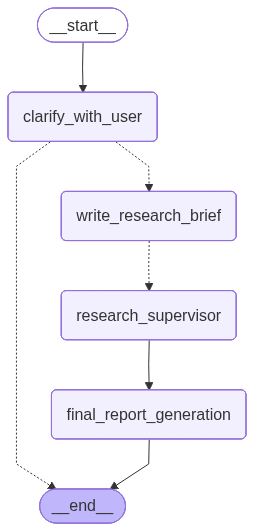

In [19]:

# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(graph.get_graph().draw_ascii())